#Input Handling and Data Preprocessing

##Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

##Importing the dataset


In [2]:
%cd /content/problems

/content/problems


In [3]:
folder_path = '.'
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Print the file paths
for file_path in csv_files:
    print(file_path)

./occlusion1_sol.csv
./frag01_sol.csv
./occlusion2_sol.csv
./frag1.csv
./isolated_sol.csv
./isolated.csv
./frag2.csv
./occlusion2.csv
./occlusion1.csv
./frag0.csv
./frag2_sol.csv


##Utility Functions

In [4]:
def group_segments_by_curve(csv_file, tolerance=1e-5):


    # Read the CSV file
    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

    # Initialize variables
    segments = []
    for segment_no in df['segment_no'].unique():
        segment_df = df[df['segment_no'] == segment_no]
        for sub_segment in segment_df['sub_segment'].unique():
            sub_segment_df = segment_df[segment_df['sub_segment'] == sub_segment]
            x_start = sub_segment_df['x'].values[0]
            y_start = sub_segment_df['y'].values[0]
            x_end = sub_segment_df['x'].values[-1]
            y_end = sub_segment_df['y'].values[-1]
            start_point = (x_start, y_start)
            end_point = (x_end, y_end)
            segments.append(((segment_no, sub_segment), start_point, end_point))

    # Lists to store curves
    closed_curves = []
    open_curves = []

    # Function to check if two points are approximately equal within tolerance
    def points_match(point1, point2, tol):
        return np.linalg.norm(np.array(point1) - np.array(point2)) < tol

    # Iterate over segments
    for i in range(len(segments)):
        current_segment = segments[i]
        cur_segment_id = current_segment[0] #tuple (segment_no, segment_id)
        cur_start_point = current_segment[1]
        cur_end_point = current_segment[2]

        # Flag to determine if added to an existing curve
        added_to_curve = False

        # Check if current segment matches any open curve
        for curve in open_curves:
            first_segment_id = curve[0]
            last_segment_id = curve[-1]

            first_segment = next(seg for seg in segments if seg[0] == first_segment_id)
            last_segment = next(seg for seg in segments if seg[0] == last_segment_id)

            if points_match(last_segment[2], cur_start_point, tolerance):
                # Add to the existing curve
                curve.append(cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_end_point, tolerance):
                    # Curve is closed
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break
            elif points_match(first_segment[1], cur_end_point, tolerance):
                # Add to the existing curve
                curve.insert(0, cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_start_point, tolerance):
                    # Curve is closed
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break

        # If not added to any existing curve, start a new open curve
        if not added_to_curve:
            if points_match(cur_start_point, cur_end_point, tolerance):
                # Curve is closed
                closed_curves.append([cur_segment_id])
            else:
                open_curves.append([cur_segment_id])

    return segments, closed_curves, open_curves

In [5]:
def extract_all_points_from_curve(curve, csv_file):
    """Extract all points for the segments in the given curve from the CSV file."""
    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

    # Create a set of tuples from the curve list for filtering
    curve_set = set(curve)

    # Filter the DataFrame to include only rows with (segment_no, sub_segment) in the curve
    curve_segments = df[df.apply(lambda row: (row['segment_no'], row['sub_segment']) in curve_set, axis=1)]

    # Extract points
    points = curve_segments[['x', 'y']].values.tolist()
    return points

In [6]:
def read_csv(csv_path):
    """Read the CSV file into a NumPy array"""
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

#Shape Identification & Regularisation

##Importing the libraries

In [7]:
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
from io import BytesIO
from PIL import Image as PILImage

##Utility Functions

For Checking Shape Lines

In [8]:
def check_straight_line(points, tolerance):

    if len(points) < 2:
        return True  # Less than two points is trivially a straight line

    # Fit a line to the points
    X = np.array([p[0] for p in points]).reshape(-1, 1)
    y = np.array([p[1] for p in points])
    model = LinearRegression().fit(X, y)
    slope, intercept = model.coef_[0], model.intercept_

    # Calculate deviations from the line
    deviations = np.abs(np.array([p[1] for p in points]) - (slope * np.array([p[0] for p in points]) + intercept))

    # Check if all deviations are within tolerance
    return np.all(deviations < tolerance)

For Regularising Open Curves

In [9]:
def regularize_open_curves(csv_file, open_curves, tolerance=2, verbose=True):

    open_plots = []
    for curve in open_curves:
        points = extract_all_points_from_curve(curve, csv_file)
        x = [p[0] for p in points]
        y = [p[1] for p in points]

        # Smooth the y-values using Savitzky-Golay filter
        if len(y) > 5:  # Ensure enough points for the filter
            y_smoothed = savgol_filter(y, window_length=5, polyorder=2)
        else:
            y_smoothed = y

        # Check if the curve is a straight line
        if check_straight_line(points, tolerance):
            if verbose:
                print("Line detected")
            st_line_points = [x[0], y[0], x[-1], y[-1]]
            open_plots.append([st_line_points, "Line"])
        else:
            # Plot the smoothed curve
            open_plots.append([points, "Irregular"])

    return open_plots

Shape Identification Using OpenCV Contours + Mathematical Formulas (Higher accuracy than CNN)

In [10]:
def identify_shapes(contour):

    # Approximate contour
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Calculate area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Filter out small contours
    if area < 500:
        return None

    # Calculate the centroid
    M = cv2.moments(contour)
    if M["m00"] == 0:  # To prevent division by zero
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Shape classification
    shape_name = "Irregular"
    if len(approx) == 3:
        shape_name = "Triangle"
    elif len(approx) == 4:
        # Check for rectangle or square using aspect ratio
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.99 <= aspect_ratio <= 1.01:
            shape_name = "Square"
        else:
            shape_name = "Rectangle"
    elif len(approx) > 4:
        # Calculate distances from centroid to all contour points
        distances = [np.sqrt((cx - p[0][0])**2 + (cy - p[0][1])**2) for p in contour]

        # Detect peaks and valleys
        peaks = (np.diff(np.sign(np.diff(distances))) == -2).nonzero()[0] + 1
        valleys = (np.diff(np.sign(np.diff(distances))) == 2).nonzero()[0] + 1

        # Check for circle
        mean_dist = np.mean(distances)
        max_dist_deviation = 0.15 * mean_dist  # Allowable deviation (increased for rough circles)
        if all(abs(d - mean_dist) < max_dist_deviation for d in distances):
            shape_name = "Circle"
        elif len(approx) == 10 and abs(len(peaks) - len(valleys)) <= 2:
            shape_name = "Star"
        else:
            # Fit ellipse and check its properties
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                (center, axes, orientation) = ellipse
                major_axis, minor_axis = max(axes), min(axes)
                axis_ratio = minor_axis / major_axis

                # Calculate focal points
                focal_distance = np.sqrt(major_axis**2 - minor_axis**2) / 2
                angle_rad = np.deg2rad(orientation)
                focal1 = (int(center[0] + focal_distance * np.cos(angle_rad)),
                          int(center[1] + focal_distance * np.sin(angle_rad)))
                focal2 = (int(center[0] - focal_distance * np.cos(angle_rad)),
                          int(center[1] - focal_distance * np.sin(angle_rad)))

                # Check the ellipse property: sum of distances to focal points is constant
                sum_distances = []
                for p in contour:
                    d1 = np.linalg.norm(np.array(p[0]) - np.array(focal1))
                    d2 = np.linalg.norm(np.array(p[0]) - np.array(focal2))
                    sum_distances.append(d1 + d2)

                # Allow a small deviation
                max_deviation = 0.1 * np.mean(sum_distances)
                if max(sum_distances) - min(sum_distances) <= max_deviation:
                    shape_name = "Ellipse"

    # Return shape information
    return {'shape': shape_name, 'approx': approx}

Utility Function For plotting a curve

In [11]:
def plot_curve(curve):

    fig, ax = plt.subplots(figsize=(8, 8))

    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    points = curve[0]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    ax.plot(x, y, 'o', color='black', markersize=5)
    x_min = min(x_min, *x)
    x_max = max(x_max, *x)
    y_min = min(y_min, *y)
    y_max = max(y_max, *y)

    # Set limits based on the shapes

    ax.set_xlim(x_min - 10, x_max + 10)
    ax.set_ylim(y_min - 10, y_max + 10)
    ax.set_aspect('equal')
    ax.axis('off')  # Hide the axes
    return fig, ax

For Regularising Closed Shapes

In [12]:
def regularize_closed_curves(csv_file, closed_curves, margin, verbose=True):

    final_closed_plots = []
    for curve in closed_curves:
        points = extract_all_points_from_curve(curve, csv_file)
        adjusted_points = [[x + margin, y + margin] for x, y in points]
        closed_plot = [adjusted_points, "Original"]

        # Generate the plot using plot_curve
        fig, ax = plot_curve(closed_plot)

        # Convert the plot to a NumPy array (image format)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)  # Close the figure to free memory

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to get a binary image
        _, thresh_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

        # Find contours in the binary image
        contours, _ = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        i = 0

        # Process each contour
        for contour in contours:
            # Remove outermost contour that represents image border
            if i == 0:
                i = 1
                continue
            # Only 1 contour needed per curve
            if i > 1:
                continue
            # Calculate the centroid
            M = cv2.moments(contour)
            if M["m00"] == 0:  # To prevent division by zero
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroid = (cx, cy)

            shape_info = identify_shapes(contour)
            if shape_info:
                # Check if the shape is a known geometric shape
                if shape_info['shape'] in ["Triangle", "Square", "Rectangle", "Circle", "Ellipse", "Star"]:
                    final_closed_plots.append([points, shape_info['shape']])
                    if verbose:
                        print(f"{shape_info['shape']} detected")
                else:
                    # Draw original contour for unknown shapes
                    final_closed_plots.append([points, "Irregular"])
            i += 1

    return final_closed_plots

In [13]:
def regularize(csv_file, verbose=True):

    segments, closed_curves, open_curves = group_segments_by_curve(csv_file, tolerance=1)

    margin = 100  # Define a margin size
    closed_plots = []
    open_plots = []

    if closed_curves:
        # Regularize closed curves
        closed_plots = regularize_closed_curves(csv_file, closed_curves, margin, verbose=verbose)

    if open_curves:
        # Regularize open curves
        open_plots = regularize_open_curves(csv_file, open_curves, verbose=verbose)

    # Combine both closed and open plots
    all_plots = closed_plots + open_plots

    return all_plots

In [14]:
def get_regularized_image(plot_list, filename="regularized_image.png", padding=0.5):
    # Create a new figure for combined plots
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')

    # Plot all curves using plot_curve on the same axis
    for curve in plot_list:
        points, shape_name = curve

        if shape_name == "Line":
            x_start, y_start, x_end, y_end = points
            ax.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=3)

        elif shape_name == "Triangle":
            # Convert points to a numpy array
            points = np.array(points)

            # Calculate the centroid (mean of the points)
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])

            # Calculate distances from centroid to each point
            distances = np.sqrt((points[:, 0] - centroid_x) ** 2 + (points[:, 1] - centroid_y) ** 2)
            mean_distance = np.mean(distances)

            # Create an equilateral triangle around the centroid
            angles = np.linspace(0, 2 * np.pi, 4)[:-1]  # 3 points for an equilateral triangle

            triangle_points = []
            for angle in angles:
                x = centroid_x + mean_distance * np.cos(angle)
                y = centroid_y + mean_distance * np.sin(angle)
                triangle_points.append([x, y])

            triangle_points = np.array(triangle_points)

            # Draw the triangle by connecting the points
            ax.plot(triangle_points[:, 0], triangle_points[:, 1], color='black', linewidth=3)
            ax.plot([triangle_points[-1, 0], triangle_points[0, 0]], [triangle_points[-1, 1], triangle_points[0, 1]], color='black', linewidth=3)

        elif shape_name == "Circle":
            # Convert points to a numpy array
            points = np.array(points)

            # Calculate the centroid (mean of the points)
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])

            # Calculate the radius as the mean distance from the centroid to each point
            distances = np.sqrt((points[:, 0] - centroid_x)**2 + (points[:, 1] - centroid_y)**2)
            radius = np.mean(distances)
            circle = plt.Circle((centroid_x, centroid_y), radius, color='black', linewidth=3, fill=False)
            ax.add_patch(circle)

        elif shape_name == "Ellipse":
            # Convert points to a numpy array
            points = np.array(points)

            # Calculate the centroid (mean of the points)
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])
            centroid = np.array([centroid_x, centroid_y])

            # Center the points by subtracting the centroid
            centered_points = points - centroid

            # Calculate the covariance matrix of the centered points
            covariance_matrix = np.cov(centered_points, rowvar=False)

            # Eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

            # Calculate the major and minor axes lengths
            major_axis_length = 2 * np.sqrt(eigenvalues[1])
            minor_axis_length = 2 * np.sqrt(eigenvalues[0])

            # Calculate the angle of the major axis with respect to the x-axis
            angle = np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1])

            # Draw the ellipse
            ellipse = plt.Ellipse(centroid, major_axis_length, minor_axis_length, np.degrees(angle), color='black', linewidth=3, fill=False)
            ax.add_patch(ellipse)

        elif shape_name in ["Rectangle", "Square"]:
            # Convert points to a numpy array for easier manipulation
            points = np.array(points)

            x_min, y_min = np.min(points, axis=0)
            x_max, y_max = np.max(points, axis=0)

            # Calculate width and height
            width = x_max - x_min
            height = y_max - y_min

            # Calculate the centroid
            centroid_x = (x_min + x_max) / 2
            centroid_y = (y_min + y_max) / 2

            # Draw the rectangle or square
            rect = plt.Rectangle((centroid_x - width / 2, centroid_y - height / 2), width, height, color='black', linewidth=3, fill=False)
            ax.add_patch(rect)

        elif shape_name == "Star":
            points = np.array(points)

            # Calculate the centroid of the star
            centroid_x = np.mean(points[:, 0])
            centroid_y = np.mean(points[:, 1])
            centroid = np.array([centroid_x, centroid_y])

            # Calculate the distance of each point from the centroid
            distances = np.sqrt((points[:, 0] - centroid_x) ** 2 + (points[:, 1] - centroid_y) ** 2)

            # Sort the points by distance to centroid
            sorted_indices = np.argsort(distances)
            sorted_points = points[sorted_indices]

            # Extract highest and lowest points
            num_peaks = 5
            num_valleys = 5

            # Extract the top 5 peaks and bottom 5 valleys
            peaks = sorted_points[-num_peaks:]
            valleys = sorted_points[:num_valleys]

            # Calculate the mean distances
            mean_peak_distance = np.mean([np.sqrt((p[0] - centroid_x) ** 2 + (p[1] - centroid_y) ** 2) for p in peaks])
            mean_valley_distance = np.mean([np.sqrt((v[0] - centroid_x) ** 2 + (v[1] - centroid_y) ** 2) for v in valleys])

            # Create star points with equal angular separation
            num_points = num_peaks + num_valleys
            angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

            # Generate star points based on calculated mean distances
            star_points = []
            for i, angle in enumerate(angles):
                if i % 2 == 0:  # Peak
                    x = centroid_x + mean_peak_distance * np.cos(angle)
                    y = centroid_y + mean_peak_distance * np.sin(angle)
                    star_points.append([x, y])
                else:  # Valley
                    x = centroid_x + mean_valley_distance * np.cos(angle)
                    y = centroid_y + mean_valley_distance * np.sin(angle)
                    star_points.append([x, y])

            star_points = np.array(star_points)

            # Draw the star by connecting the points
            ax.plot(star_points[:, 0], star_points[:, 1], color='black', linewidth=3)
            ax.plot([star_points[-1, 0], star_points[0, 0]], [star_points[-1, 1], star_points[0, 1]], color='black', linewidth=3)

        else:
            # For other shapes, plot the points as they are
            x = [p[0] for p in points]
            y = [p[1] for p in points]
            ax.plot(x, y, '.', color='black', linewidth=2)

    # Set equal scaling and title
    ax.set_aspect('equal', 'box')

    # Save plot to an in-memory buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=padding)
    plt.close(fig)

    # Load the image from the buffer and return it
    buf.seek(0)
    image = PILImage.open(buf)
    image_path = 'regularized_output.png'
    image.save(image_path)
    return image_path

Function to Plot Test Case and Rgularised Output (Side by Side)

In [15]:
def plot_side_by_side(csv_file):

    # Extract the base name of the file without the extension
    base_name = os.path.splitext(os.path.basename(csv_file))[0]

    # Read original paths from CSV
    original_paths = read_csv(csv_file)

    # Regularize curves
    regularized_plots = regularize(csv_file)

    # Create a new figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Two subplots side by side

    # Plot the original image
    ax1 = axes[0]
    for XYs in original_paths:
        for XY in XYs:
            ax1.plot(XY[:, 0], XY[:, 1], c='k', linewidth=3)
    ax1.set_aspect('equal')
    ax1.axis('off')  # Hide axes for the original image
    ax1.set_title("Original Image")

    # Plot the regularized image
    ax2 = axes[1]
    regularized_image_path = get_regularized_image(regularized_plots, filename = f"{base_name}_regularized.png", padding=0)
    regularized_image = cv2.imread(regularized_image_path)
    ax2.imshow(regularized_image)
    ax2.axis('off')  # Hide axes for the regularized image
    ax2.set_title("Regularized Image")

    plt.show()

##Calling the Regularisation & Shape Identification

Circle detected
Rectangle detected


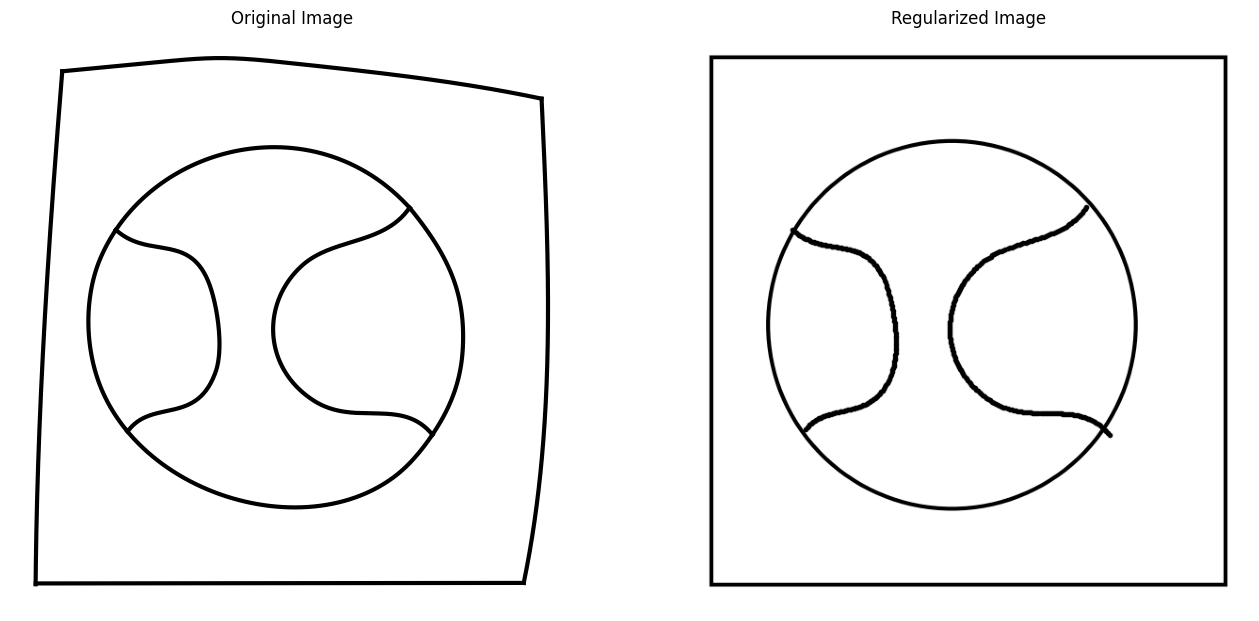

In [16]:
plot_side_by_side('frag0.csv')

Circle detected
Star detected
Rectangle detected


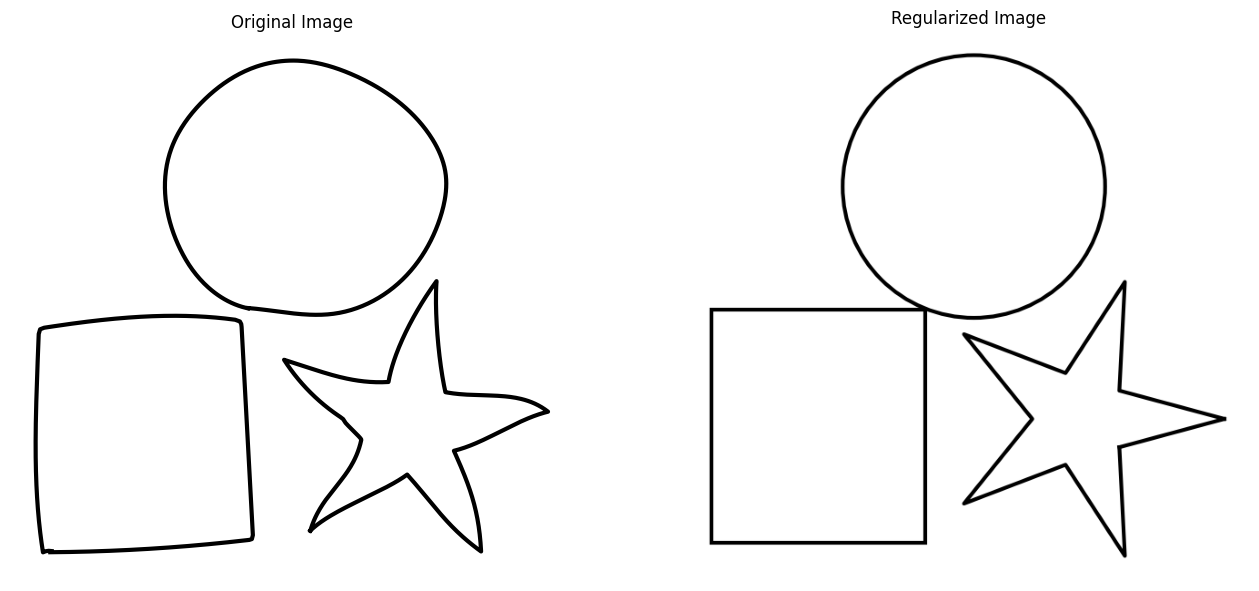

In [17]:
plot_side_by_side('isolated.csv')

Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected
Line detected


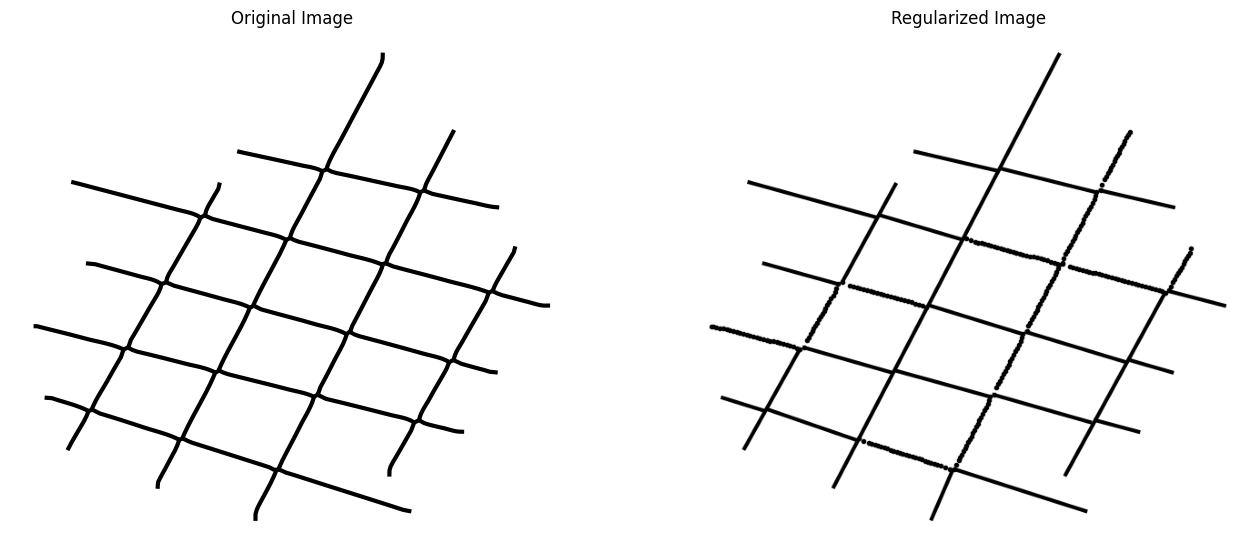

In [18]:
plot_side_by_side('frag2.csv')

#Symmetry Identification

##Utility Functions

In [19]:
def check_pairwise_vertex_symmetry(approx, tolerance):


    num_points = len(approx)
    symmetry_lines = []

    # Function to check if two points are approximately equal
    def points_are_equal(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2)) < tolerance

    # Function to reflect a point across a line defined by two points (p1, p2)
    def reflect_point(p, p1, p2):
        # Vector from p1 to p2
        v = np.array([p2[0] - p1[0], p2[1] - p1[1]])
        # Vector from p1 to point p
        u = np.array([p[0] - p1[0], p[1] - p1[1]])
        # Project u onto v to find the foot of the perpendicular
        proj = np.dot(u, v) / np.dot(v, v) * v
        foot = np.array(p1) + proj
        # Reflection vector
        reflection = 2 * (foot - np.array(p))
        return np.array(p) + reflection

    # Check for symmetry by drawing lines between each pair of points
    for i in range(num_points):
        for j in range(i + 1, num_points):
            p1 = approx[i][0]
            p2 = approx[j][0]

            is_symmetrical = True
            reflected_points = []
            for k in range(num_points):
                if k == i or k == j:
                    continue
                p = approx[k][0]
                reflected = reflect_point(p, p1, p2)
                if not any(points_are_equal(reflected, approx[m][0]) for m in range(num_points) if m != i and m != j):
                    is_symmetrical = False
                    break
                reflected_points.append(tuple(reflected))

             # If all reflected points match the given points, record the line of symmetry
            if is_symmetrical:
                # Check if this symmetry line is not already in the result list
                symmetry_line = (tuple(p1), tuple(p2))
                if symmetry_line not in symmetry_lines and (tuple(p2), tuple(p1)) not in symmetry_lines:
                    symmetry_lines.append(symmetry_line)

    return symmetry_lines

In [20]:
def check_perpendicular_bisector_symmetry(approx):

    num_points = len(approx)

    symmetry_lines = []

    def points_are_equal(p1, p2, tolerance=5):
        return np.linalg.norm(np.array(p1) - np.array(p2)) < tolerance

    def is_duplicate_line(new_line, existing_lines, tolerance=2):
        new_midpoint, new_slope = new_line
        for midpoint, slope in existing_lines:
            if abs(midpoint[0] - new_midpoint[0]) < tolerance or abs(midpoint[1] - new_midpoint[1]) < tolerance:
                return True
        return False

    for i in range(num_points):
        p1 = approx[i][0]
        p2 = approx[(i + 1) % num_points][0]

        # Midpoint of the edge
        mx = (p1[0] + p2[0]) // 2
        my = (p1[1] + p2[1]) // 2

        # Slope of the line (p1, p2)
        if p1[0] == p2[0]:
            slope = np.inf  # vertical line
        else:
            slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

        # Slope of the perpendicular bisector
        if slope == 0:
            perp_slope = np.inf  # vertical line
        elif slope == np.inf:
            perp_slope = 0  # horizontal line
        else:
            perp_slope = -1 / slope

        # Equation of the perpendicular bisector line
        is_symmetrical = True
        for k in range(num_points):
            p = approx[k][0]
            # print(f"Point {p}")
            if perp_slope == np.inf:
                # Check vertical line symmetry
                reflected = (2 * mx - p[0], p[1])
            elif perp_slope == 0:
                # Check horizontal line symmetry
                reflected = (p[0], 2 * my - p[1])
            else:
                # Check for other slopes
                # Line equation: y = perp_slope * (x - mx) + my
                c = my - perp_slope * mx
                x = (p[0] + perp_slope * (p[1] - c)) / (1 + perp_slope ** 2)
                y = perp_slope * x + c
                reflected = (2 * x - p[0], 2 * y - p[1])

            # print(f"Reflected Point {reflected}")

            if not any(points_are_equal(reflected, approx[m][0]) for m in range(num_points) if m != k):
                is_symmetrical = False
                break

        if is_symmetrical:
            symmetry_line = ((mx, my), perp_slope)
            if not is_duplicate_line(symmetry_line, symmetry_lines):
                symmetry_lines.append(symmetry_line)

    return symmetry_lines

For drawing dashed lines to visualise the symmetry

In [21]:
def draw_dashed_line(img, start_point, end_point, color, thickness=1, dash_length=10):
    """
    Draw a dashed line on the image.
    """
    # Calculate the line length
    line_length = int(np.linalg.norm(np.array(end_point) - np.array(start_point)))

    # Calculate the number of dashes
    num_dashes = line_length // dash_length

    # Calculate direction vector of the line
    direction = np.array(end_point) - np.array(start_point)
    direction = direction / np.linalg.norm(direction)

    for i in range(num_dashes):
        start_dash = start_point + direction * (i * dash_length)
        end_dash = start_dash + direction * (dash_length / 2)
        start_dash = tuple(start_dash.astype(int))
        end_dash = tuple(end_dash.astype(int))
        cv2.line(img, start_dash, end_dash, color, thickness)

In [22]:
def check_symmetry(csv_file):

    # Regularize curves
    regularized_plots = regularize(csv_file, verbose=False)
     # Extract the base name of the file without the extension
    base_name = os.path.splitext(os.path.basename(csv_file))[0]

    # Get the regularized image path
    regularized_image_path = get_regularized_image(regularized_plots, filename = f"{base_name}_regularized.png", padding=0)

    # Read the regularized image
    regularized_image = cv2.imread(regularized_image_path)
    if regularized_image is None:
        print(f"Error: Unable to load image at path {regularized_image_path}")
        return

    # Define colors for specific shapes
    colors = {
    "Square": (0, 100, 0),        # Dark Green
    "Rectangle": (0, 0, 255),     # Blue
    "Ellipse": (139, 0, 0),       # Dark Red
    "Star": (255, 140, 0),        # Dark Orange
    "Circle": (139, 0, 139),      # Dark Magenta
    "Triangle": (0, 255, 0),      # Green
    "Irregular": (85, 107, 47),   # Dark Olive Green
    }

    # Create a copy of the original image for drawing symmetry lines
    symmetry_image = regularized_image.copy()
    gray_image = cv2.cvtColor(symmetry_image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to get a binary image
    _, thresh_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # List to store shape information
    shapes = []
    used_centroids = []
    i = 0

    # Iterate through each contour to classify and label shapes
    for contour in contours:
        if i == 0:
            i = 1
            continue
        # Approximate contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Calculate area and perimeter
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        # Filter out small contours
        if area < 500:
            continue

        # Calculate the centroid
        M = cv2.moments(contour)
        if M["m00"] == 0:  # To prevent division by zero
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroid = (cx, cy)

        # Filter out contours that are too close to already processed ones
        if any(np.linalg.norm(np.array(centroid) - np.array(c)) < 10 for c in used_centroids):
            continue
        used_centroids.append(centroid)
        shape = identify_shapes(contour)
        shape_name = shape['shape']
        approx = shape['approx']

        # Get the color for the shape from the dictionary
        color = colors.get(shape_name, (0, 0, 0))  # Default to black if shape not in dictionary

        if shape_name == "Circle":
            # Draw dashed radial lines from the center
            cx, cy = int(np.mean([p[0][0] for p in approx])), int(np.mean([p[0][1] for p in approx]))
            mean_radius = np.mean([np.sqrt((cx - p[0][0])**2 + (cy - p[0][1])**2) for p in approx])
            angles = np.linspace(0, 2 * np.pi, 17)  # Draw 16 radial lines
            for angle in angles:
                end_x = int(cx + mean_radius * np.cos(angle))
                end_y = int(cy + mean_radius * np.sin(angle))
                draw_dashed_line(symmetry_image, (cx, cy), (end_x, end_y), color)
            print("Circle with radial symmetry (few lines shown)")

        else:
            if shape_name == "Irregular":
                pairwise_vertex_symmetry_lines = check_pairwise_vertex_symmetry(approx, tolerance = 20) # Higher tolerance for irregular shapes
            else:
                pairwise_vertex_symmetry_lines = check_pairwise_vertex_symmetry(approx, tolerance = 5) # Lower tolerance for regular shapes

            perpendicular_bisector_symmetry_lines = check_perpendicular_bisector_symmetry(approx)

            # Draw symmetry lines joining vertices
            for line in pairwise_vertex_symmetry_lines:
                draw_dashed_line(symmetry_image, line[0], line[1], color)

            # Draw perpendicular bisector symmetry lines within shape
            min_x = np.min(approx[:, 0, 0])
            max_x = np.max(approx[:, 0, 0])
            min_y = np.min(approx[:, 0, 1])
            max_y = np.max(approx[:, 0, 1])

            for mid, slope in perpendicular_bisector_symmetry_lines:
                if slope == np.inf:
                    # Vertical line within the bounding box
                    start_point = (mid[0], min_y)
                    end_point = (mid[0], max_y)
                else:
                    # Calculate intersection points of the bisector with the bounding box
                    x1 = min_x
                    y1 = int(slope * (x1 - mid[0]) + mid[1])
                    x2 = max_x
                    y2 = int(slope * (x2 - mid[0]) + mid[1])

                    # Ensure the points are within the bounding box
                    if y1 < min_y:
                        y1 = min_y
                        x1 = int((y1 - mid[1]) / slope + mid[0])
                    elif y1 > max_y:
                        y1 = max_y
                        x1 = int((y1 - mid[1]) / slope + mid[0])

                    if y2 < min_y:
                        y2 = min_y
                        x2 = int((y2 - mid[1]) / slope + mid[0])
                    elif y2 > max_y:
                        y2 = max_y
                        x2 = int((y2 - mid[1]) / slope + mid[0])

                    start_point = (x1, y1)
                    end_point = (x2, y2)

                # Draw the dashed line
                draw_dashed_line(symmetry_image, start_point, end_point, color, dash_length=10)

            total_symmetry_lines = len(pairwise_vertex_symmetry_lines) + len(perpendicular_bisector_symmetry_lines)
            if total_symmetry_lines != 0:
                print(f"{shape_name} shape with {total_symmetry_lines} lines of symmetry")

    # Create a figure with two subplots
    plt.figure(figsize=(15, 10))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(regularized_image)
    plt.title("Regularized Image")
    plt.axis('off')

    # Plot the symmetrical image
    plt.subplot(1, 2, 2)
    plt.imshow(symmetry_image)
    plt.title("Lines of Symmetry")
    plt.axis('off')

    # Show the combined plot
    plt.show()

##Calling Symmetry Identification

Rectangle shape with 2 lines of symmetry
Circle with radial symmetry (few lines shown)
Irregular shape with 1 lines of symmetry


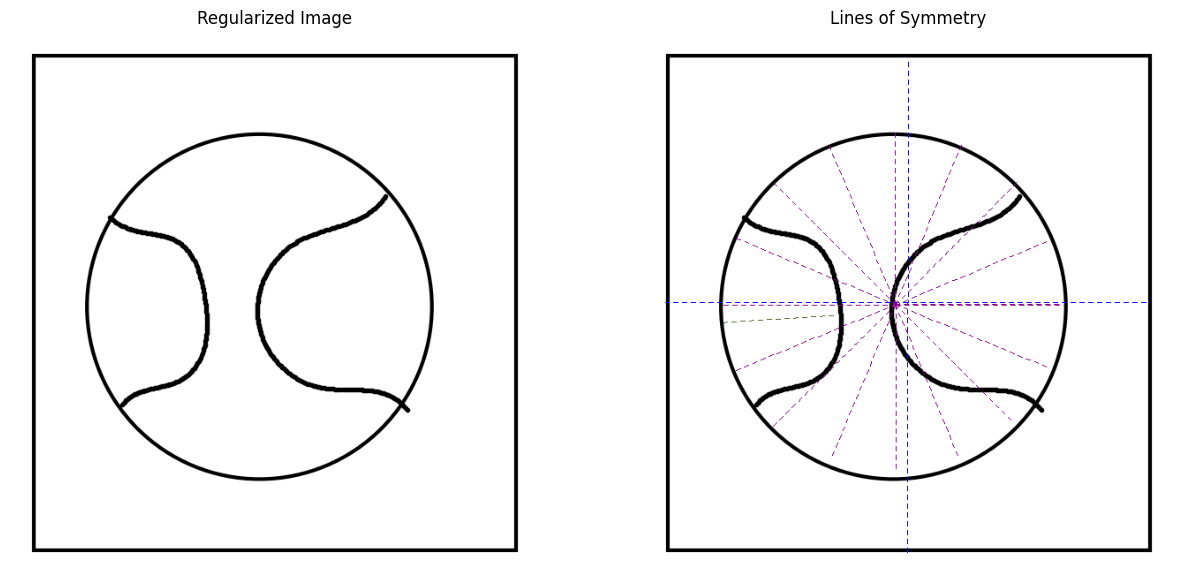

In [23]:
check_symmetry('frag0.csv')

Star shape with 5 lines of symmetry
Rectangle shape with 2 lines of symmetry
Circle with radial symmetry (few lines shown)


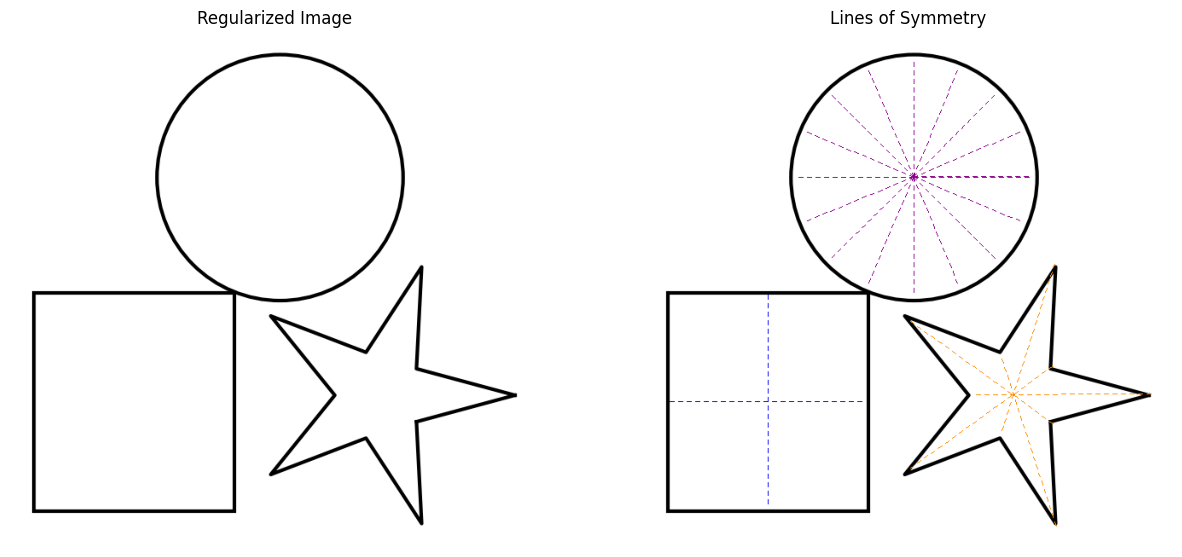

In [24]:
check_symmetry('isolated.csv')

#Occlusion Solution

Using Model Fitting

##Importing The libraries

In [25]:
import random
from skimage.measure import EllipseModel, CircleModel
import scipy.optimize as opt
from tqdm import tqdm
import csv

##Utility Functions

In [26]:
def custom_ransac_ellipse(points, max_trials=1000, residual_threshold=2):

    points = np.array(points)  # Convert to NumPy array if not already
    best_model = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_trials):
        # Randomly select 5 indices
        sample_indices = random.sample(range(len(points)), 5)

        # Use these indices to get the corresponding points
        sample_points = points[sample_indices]

        # Fit an ellipse model to these points
        model = EllipseModel()
        if not model.estimate(sample_points):
            continue

        # Calculate the residuals (distances of points to the fitted ellipse)
        residuals = np.abs(model.residuals(points))

        # Determine inliers
        inliers = residuals < residual_threshold
        num_inliers = np.sum(inliers)

        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_model = model
            best_inliers = inliers
            max_inliers = num_inliers

    return best_model, best_inliers

In [27]:
def custom_ransac_circle(points, max_trials=1000, residual_threshold=2):

    points = np.array(points)
    best_model = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_trials):
        # Randomly select 3 indices
        sample_indices = random.sample(range(len(points)), 3)
        sample_points = points[sample_indices]

        # Fit a circle model to these points
        model = CircleModel()
        if not model.estimate(sample_points):
            continue

        # Calculate the residuals (distances of points to the fitted circle)
        residuals = np.abs(model.residuals(points))

        # Determine inliers
        inliers = residuals < residual_threshold
        num_inliers = np.sum(inliers)

        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_model = model
            best_inliers = inliers
            max_inliers = num_inliers

    return best_model, best_inliers

In [28]:
# Define a cost function to minimize the geometric distance to the ellipse
def cost_function(params, points):
    xc, yc, a, b, theta = params
    total_distance = 0
    for (x, y) in points:
        x_rot = (x - xc) * np.cos(theta) + (y - yc) * np.sin(theta)
        y_rot = -(x - xc) * np.sin(theta) + (y - yc) * np.cos(theta)
        distance = (x_rot / a)**2 + (y_rot / b)**2 - 1
        total_distance += np.abs(distance)
    return total_distance

In [29]:
def remove_coincident_points(points, curve_boundary, tolerance):
    remaining_points = []

    for point in points:
        is_coincident = False
        for boundary_point in curve_boundary:
            if np.linalg.norm(np.array(point) - np.array(boundary_point)) <= tolerance:
                is_coincident = True
                break
        if not is_coincident:
            remaining_points.append(point)

    return np.array(remaining_points)

In [30]:
def plot(paths_XYs, title, ax):

    colours = ['red', 'green', 'blue', 'yellow', 'purple']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.scatter(XY[:, 0], XY[:, 1], c=c, s=50)
    ax.set_aspect('equal')
    ax.set_title(title)

In [31]:
def get_ellipse_boundary_points(ellipse, count=100):

    (x0, y0), (a, b), theta = ellipse
    boundary_points = []

    for t in np.linspace(0, 2 * np.pi, count):
        x = a / 2 * np.cos(t)
        y = b / 2 * np.sin(t)
        x_rot = x * np.cos(np.radians(theta)) - y * np.sin(np.radians(theta))
        y_rot = x * np.sin(np.radians(theta)) + y * np.cos(np.radians(theta))
        boundary_points.append([x_rot + x0, y_rot + y0])

    return np.array(boundary_points)

In [32]:
def get_circle_boundary_points(circle, count=100):

    (x0, y0), radius = circle
    boundary_points = []

    for t in np.linspace(0, 2 * np.pi, count):
        x = radius * np.cos(t)
        y = radius * np.sin(t)
        boundary_points.append([x + x0, y + y0])

    return np.array(boundary_points)

In [33]:
def process_curves_and_save_to_csv(input_csv_file, closed_curves, output_csv_file):

    def calculate_residuals(points, model_boundary_points):
        """ Calculate the sum of residuals between points and model boundary points. """
        return np.sum([np.min([np.linalg.norm(p - mbp) for mbp in model_boundary_points]) for p in points])

    def fit_ellipse(remaining_points):
        """ Fit an ellipse to the remaining points using RANSAC. """
        model_ellipse, inliers = custom_ransac_ellipse(remaining_points)
        if model_ellipse is not None:
            xc, yc, a, b, theta = model_ellipse.params
            ellipse = ((xc, yc), (2 * a, 2 * b), np.degrees(theta))
            initial_guess = (ellipse[0][0], ellipse[0][1], ellipse[1][0] / 2, ellipse[1][1] / 2, np.radians(ellipse[2]))
            result = opt.minimize(cost_function, initial_guess, args=(remaining_points,), method='L-BFGS-B')
            xc, yc, a, b, theta = result.x
            refined_ellipse = ((xc, yc), (2 * a, 2 * b), np.degrees(theta))
            return get_ellipse_boundary_points(refined_ellipse, len(remaining_points))
        return None

    def fit_circle(remaining_points):
        """ Fit a circle to the remaining points using RANSAC. """
        model_circle, inliers = custom_ransac_circle(remaining_points)
        if model_circle is not None:
            xc, yc, r = model_circle.params
            circle = ((xc, yc), r)
            return get_circle_boundary_points(circle, len(remaining_points))
        return None

    print(f'Total curves to process: {len(closed_curves)}')

    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        i = 0
        for idx, curve in tqdm(enumerate(closed_curves), total=len(closed_curves), desc=f'Processing curves'):
            i += 1
            points = extract_all_points_from_curve(curve, input_csv_file)

            # Remove points that coincide with any other curve
            remaining_points = points
            for j, other_curve in enumerate(closed_curves):
                if j != idx:
                    remaining_points = remove_coincident_points(remaining_points, extract_all_points_from_curve(other_curve, input_csv_file), tolerance=1)

            if len(remaining_points) < 5:
                print(f"\nSkipping curve {idx} - Not enough remaining points to process after removing coincident points.")
                continue

            # Fit ellipse with progress bar
            with tqdm(total=1, desc=f'Fitting Ellipse to Curve {idx}', position=1, leave=False) as pbar:
                ellipse_boundary = fit_ellipse(remaining_points)
                pbar.update(1)

            # Fit circle with progress bar
            with tqdm(total=1, desc=f'Fitting Circle to Curve {idx}', position=1, leave=False) as pbar:
                circle_boundary = fit_circle(remaining_points)
                pbar.update(1)

            # Calculate residuals for both models
            ellipse_residuals = calculate_residuals(remaining_points, ellipse_boundary) if ellipse_boundary is not None else float('inf')
            circle_residuals = calculate_residuals(remaining_points, circle_boundary) if circle_boundary is not None else float('inf')

            # Determine the better model
            if ellipse_residuals < circle_residuals:
                print("\nEllipse provides a better fit.\n")
                best_boundary = ellipse_boundary
                best_model_type = "ellipse"
            else:
                print("\nCircle provides a better fit.\n")
                best_boundary = circle_boundary
                best_model_type = "circle"

            if best_boundary is not None:
                # Check if the remaining points coincide with the best boundary
                remaining_points_after_check = remove_coincident_points(remaining_points, best_boundary, tolerance=1.5)
                model_coincides = len(remaining_points_after_check) == 0

                if model_coincides:
                    # Store the boundary points of the best-fitting model in the CSV file
                    for point in best_boundary:
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])

                    # Also write the original points after removing those coinciding with the best boundary
                    for point in remove_coincident_points(points, best_boundary, tolerance=1.5):
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])
                else:
                    print(f"The best model ({best_model_type}) does not fully coincide with the points.")
                    # Store the original points in the CSV file
                    for point in points:
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])
            else:
                print("\nNo valid model was found.")
                # Store the original points in the CSV file
                for point in points:
                    writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])

    print(f"\nProcessed curves saved to {output_csv_file}")

In [34]:
def complete_curves(input_csv, method):
  base_name = os.path.splitext(input_csv)[0]
  output_csv = f"{base_name}_{method}_output.csv"

  # Process the curves and save to the new output CSV
  segments, closed_curves, open_curves = group_segments_by_curve(input_csv, tolerance=1)
  process_curves_and_save_to_csv(input_csv, closed_curves, output_csv)

In [35]:
def visualize_completed_curves(input_csv, method):
  input_data = read_csv(input_csv)
  base_name = os.path.splitext(input_csv)[0]
  output_csv = f"{base_name}_{method}_output.csv"
  output_data = read_csv(output_csv)

  # Plot side by side
  fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
  plot(input_data, 'Original Data', axs[0])
  plot(output_data, 'Processed Data', axs[1])
  plt.show()

##Calling Occlusion Model

In [75]:
complete_curves('occlusion1.csv', 'interpolate')

Total curves to process: 3


Fitting Ellipse to Curve 0: 100%|██████████| 1/1 [01:21<00:00, 81.29s/it]
                                                                         
Fitting Circle to Curve 0: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 1: 100%|██████████| 1/1 [00:52<00:00, 52.87s/it]
                                                                         
Fitting Circle to Curve 1: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]
                                                                        


Ellipse provides a better fit.



Processing curves:  67%|██████▋   | 2/3 [02:19<01:07, 67.12s/it]

The best model (ellipse) does not fully coincide with the points.



Fitting Ellipse to Curve 2: 100%|██████████| 1/1 [00:22<00:00, 22.26s/it]
                                                                         
Fitting Circle to Curve 2:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/skimage/measure/fit.py:308: UserWarning: Input does not contain enough significant data points.
  warn("Input does not contain enough significant data points.")

Processing curves: 100%|██████████| 3/3 [02:42<00:00, 54.16s/it]


Ellipse provides a better fit.


Processed curves saved to occlusion1_interpolate_output.csv


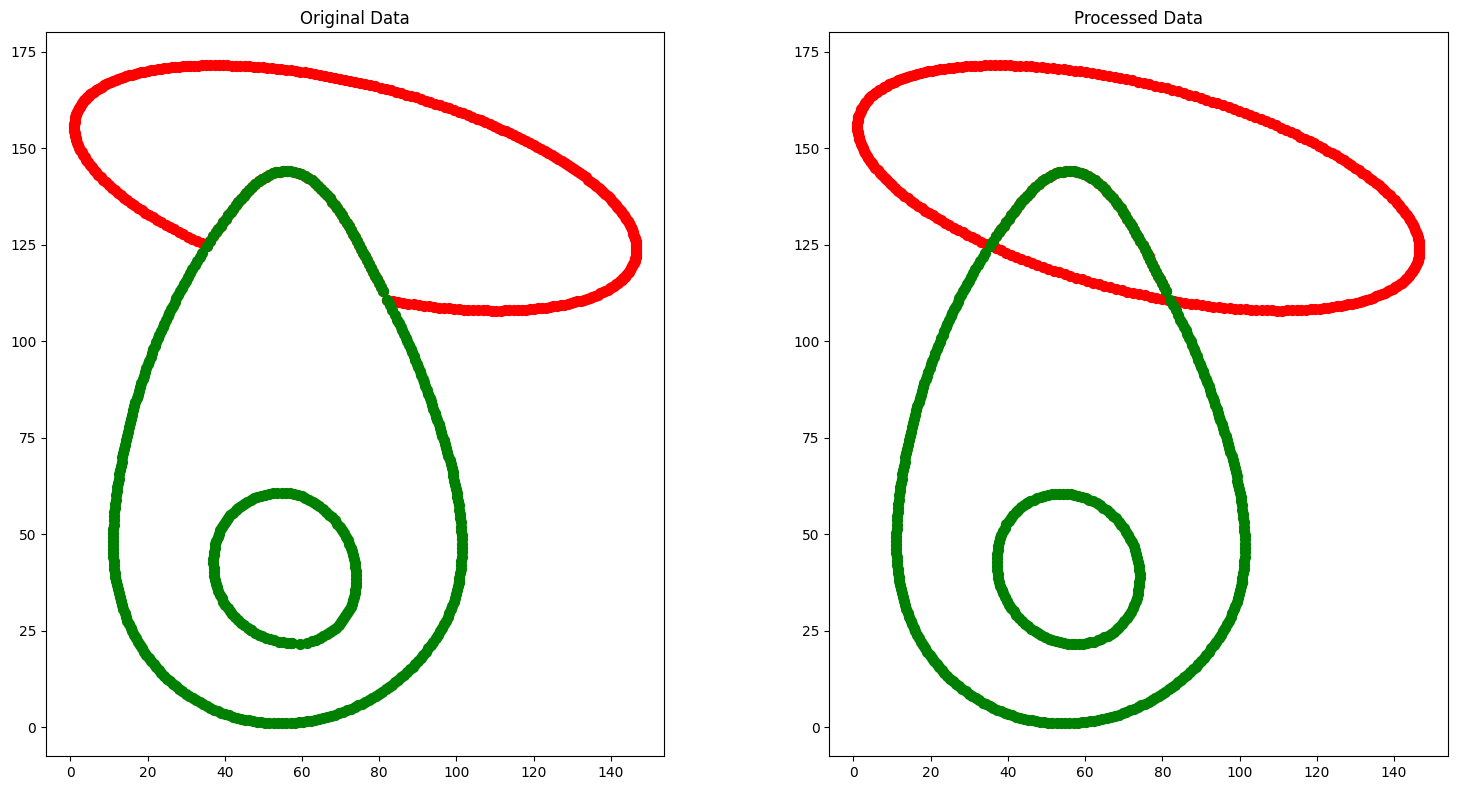

In [76]:
visualize_completed_curves('occlusion1.csv', 'interpolate')

In [77]:
complete_curves('occlusion2.csv', 'interpolate')

Total curves to process: 5


Processing curves:  20%|██        | 1/5 [00:00<00:01,  3.13it/s]


Skipping curve 0 - Not enough remaining points to process after removing coincident points.


Processing curves:  40%|████      | 2/5 [00:00<00:01,  2.56it/s]


Skipping curve 1 - Not enough remaining points to process after removing coincident points.



Fitting Ellipse to Curve 2: 100%|██████████| 1/1 [00:58<00:00, 58.32s/it]
                                                                         
Fitting Circle to Curve 2: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 3: 100%|██████████| 1/1 [00:50<00:00, 50.99s/it]
                                                                         
Fitting Circle to Curve 3: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 4: 100%|██████████| 1/1 [00:57<00:00, 57.37s/it]
                                                                         
Fitting Circle to Curve 4: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                                                        


Ellipse provides a better fit.



Processing curves: 100%|██████████| 5/5 [03:00<00:00, 36.03s/it]


Processed curves saved to occlusion2_interpolate_output.csv


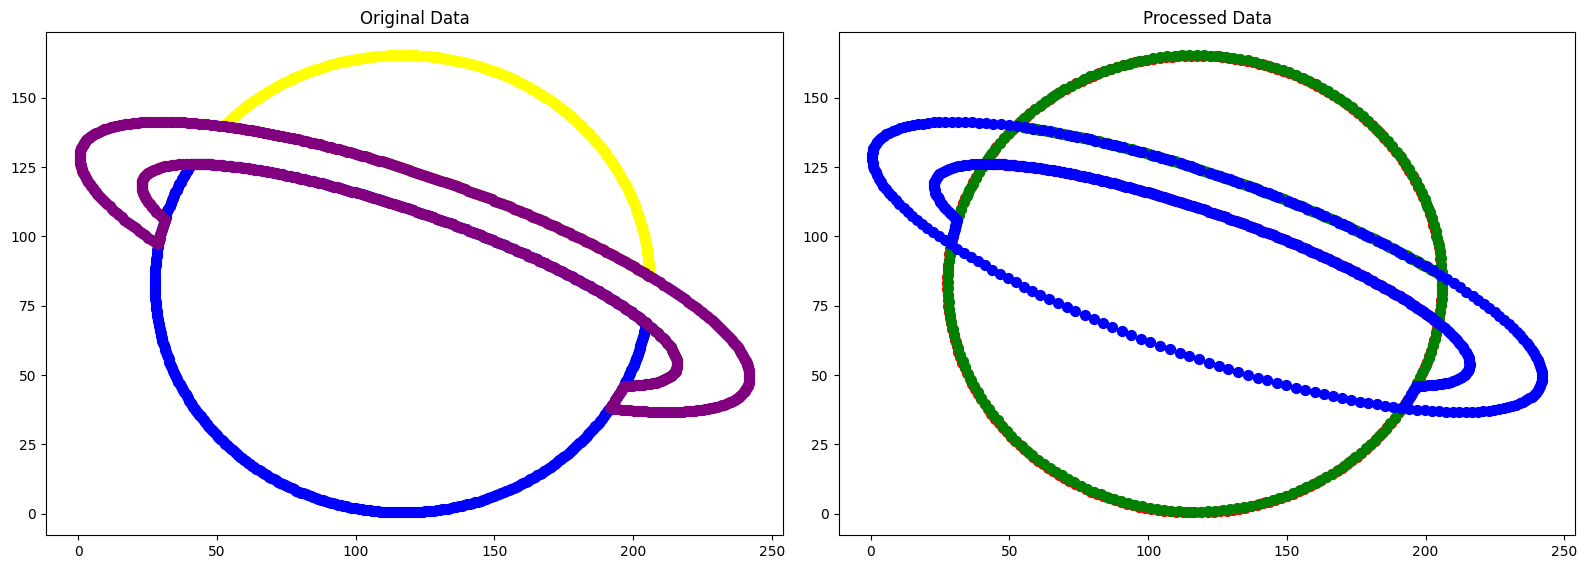

In [79]:
visualize_completed_curves('occlusion2.csv', 'interpolate')